In [9]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
import matplotlib as plt
from shapely.geometry import Polygon, MultiPolygon, shape, Point
from sklearn.cluster import DBSCAN
from shapely.ops import unary_union
import plotly.graph_objects as go
from shapely.geometry import MultiPoint, box
from plotly.subplots import make_subplots
from datetime import datetime
import seaborn as sns
from tqdm import tqdm

with open('token.txt', 'r') as f:
    TOKEN = f.read()
    px.set_mapbox_access_token(TOKEN)

In [10]:
# Function to wrap all the processing
"""
    Statically loads the data and get the clusters of fires by date and time.

    Returns:
    pd.DataFrame: clusters
    pd.DataFrame: mbrs
"""
def getClusterData():
    def parse_time(value):
        hours = value // 100
        minutes = value % 100
        return pd.to_timedelta(f"{hours} hours {minutes} minutes")

    df = pd.read_parquet('../django-api/api/fires_merged.parquet')

    a = df[['latitude', 'longitude', 'type']].copy()

    # Filter null types
    a = a[a['type'].notnull()]

    # Filter only volcanoes
    a = a[a['type'] == 1]

    clustered_data = pd.DataFrame()
    mbr_data = pd.DataFrame()

    min_samples = 2
    epsilon = 0.028

    subset = a.copy()
    
    if len(subset) >= min_samples:
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(subset[['latitude', 'longitude']])
        subset['cluster'] = db.labels_

        # Get the MBR data
        for cluster_label in np.unique(db.labels_):
            if cluster_label == -1:
                continue
            cluster_points = subset[subset['cluster'] == cluster_label][['latitude', 'longitude']]

            mbr = MultiPoint(cluster_points.values).envelope

            mbr_df = pd.DataFrame({
                'cluster': [cluster_label],
                'mbr': [mbr],
            })
            mbr_data = pd.concat([mbr_data, mbr_df], axis=0)
        clustered_data = pd.concat([clustered_data, subset], ignore_index=True)

    return (clustered_data.reset_index(drop=True), mbr_data.reset_index(drop=True))

In [11]:
clusters, mbrs = getClusterData()

FileNotFoundError: [Errno 2] No such file or directory: '../django-api/api/fires_merged.parquet'

In [ ]:
clusters.head()

,latitude,longitude,type,cluster
0,-37.854763,-71.160484,1.0,0
1,-42.833313,-72.653496,1.0,1
2,-42.830956,-72.662125,1.0,1
3,-42.832077,-72.658012,1.0,1
4,-42.835892,-72.664436,1.0,1


In [ ]:
mbrs.head()

,cluster,mbr
0,0,"POLYGON ((-37.858006 -71.1675, -37.8491 -71.16..."
1,1,"POLYGON ((-42.8446 -72.670471, -42.826958 -72...."
2,2,"POLYGON ((-41.3412 -72.62542, -41.3164 -72.625..."
3,3,"POLYGON ((-39.4331 -71.9834, -39.4076 -71.9834..."
4,4,"POLYGON ((-40.5314 -72.0343, -40.531 -72.0343,..."


In [ ]:
geo_df = gpd.GeoDataFrame(geometry=mbrs['mbr'], data=mbrs.drop(columns=['mbr']))

In [ ]:
geo_df

,cluster,geometry
0,0,"POLYGON ((-37.85801 -71.16750, -37.84910 -71.1..."
1,1,"POLYGON ((-42.84460 -72.67047, -42.82696 -72.6..."
2,2,"POLYGON ((-41.34120 -72.62542, -41.31640 -72.6..."
3,3,"POLYGON ((-39.43310 -71.98340, -39.40760 -71.9..."
4,4,"POLYGON ((-40.53140 -72.03430, -40.53100 -72.0..."
5,5,"POLYGON ((-36.87570 -71.39300, -36.85650 -71.3..."


In [ ]:
fig = px.scatter_mapbox(
    clusters,
    lat="latitude",
    lon="longitude",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=5,
    title='Fires Clustered by DBSCAN'
)

for i, row in geo_df.iterrows():
    min_lat, min_lon, max_lat, max_lon = row['geometry'].bounds

    rectangle = go.Scattermapbox(
        lat=[min_lat, max_lat, max_lat, min_lat, min_lat],
        lon=[min_lon, min_lon, max_lon, max_lon, min_lon],
        mode="lines",
        line=dict(color='white'),
        fill='toself',
        fillcolor='rgba(255,0,0,0.3)',
        showlegend=False
    )
    fig.add_trace(rectangle)

fig.update_layout(
    mapbox_style='satellite',
    title='Fires Clustered by DBSCAN',
    height=800
)

# Show the plot
fig.show()

In [ ]:
def filter_by_area(points_df, polygons_df, lat_col='latitude', lon_col='longitude'):
    points_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df[lat_col], points_df[lon_col]))
    filtered_points = points_gdf[~(points_gdf.within(polygons_df.unary_union))]
    return points_df[points_df.index.isin(filtered_points.index)]

In [ ]:
points_df = pd.read_json('./test_data.json')
points_df.head()

,id,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,ftype
0,799,-34.32245,-70.73393,304.85,0.40,0.44,2024-01-12,518,1,VIIRS,n,2.0NRT,286.28,0.73,N,NaN
1,800,-34.10534,-70.45562,340.10,0.39,0.44,2024-01-12,518,1,VIIRS,n,2.0NRT,286.28,6.41,N,NaN
2,801,-33.29236,-70.72990,315.81,0.42,0.45,2024-01-12,518,1,VIIRS,n,2.0NRT,282.05,2.06,N,NaN
3,802,-32.80292,-70.95407,306.76,0.44,0.46,2024-01-12,518,1,VIIRS,n,2.0NRT,286.78,1.93,N,NaN
4,803,-39.41776,-71.94116,337.79,0.55,0.43,2024-01-12,520,1,VIIRS,n,2.0NRT,278.31,37.66,N,NaN


In [ ]:
filter_by_area(points_df, geo_df)

,id,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,ftype
0,799,-34.32245,-70.73393,304.85,0.40,0.44,2024-01-12,518,1,VIIRS,n,2.0NRT,286.28,0.73,N,NaN
1,800,-34.10534,-70.45562,340.10,0.39,0.44,2024-01-12,518,1,VIIRS,n,2.0NRT,286.28,6.41,N,NaN
2,801,-33.29236,-70.72990,315.81,0.42,0.45,2024-01-12,518,1,VIIRS,n,2.0NRT,282.05,2.06,N,NaN
3,802,-32.80292,-70.95407,306.76,0.44,0.46,2024-01-12,518,1,VIIRS,n,2.0NRT,286.78,1.93,N,NaN
6,805,-36.78181,-73.13027,299.19,0.47,0.48,2024-01-12,520,1,VIIRS,n,2.0NRT,283.01,1.06,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,993,-33.28785,-70.59742,354.92,0.45,0.63,2024-01-12,1921,1,VIIRS,n,2.0NRT,310.81,30.88,D,NaN
195,994,-33.28691,-70.59388,367.00,0.45,0.63,2024-01-12,1921,1,VIIRS,h,2.0NRT,307.15,41.87,D,NaN
196,995,-33.28405,-70.58311,367.00,0.46,0.63,2024-01-12,1921,1,VIIRS,h,2.0NRT,302.43,97.98,D,NaN
197,996,-31.00283,-70.51562,345.33,0.53,0.67,2024-01-12,1921,1,VIIRS,n,2.0NRT,309.77,24.24,D,NaN


In [12]:
from fastkml import kml

solarpanels = []

# Load the KML file
kml_file = kml.KML()
#with open('./solarpanels_polygons.kml', 'rb') as f:
with open('./places.kml', 'rb') as f:
    kml_file.from_string(f.read())

for f in kml_file.features():
    print(f.name)
    for f2 in f.features():
        print(f2.name)
        print(f2.geometry)
        solarpanels.append(f2.geometry)

# Solar panels gpd
solarpanels_gpd = gpd.GeoDataFrame(geometry=solarpanels)

Sin título
panelsolar
POLYGON((-70.01175237342883 -23.44523222737823 0.0, -70.00234734242672 -23.44291745130679 0.0, -70.00384545630335 -23.435873233722 0.0, -70.01186748450418 -23.43761157932923 0.0, -70.01175237342883 -23.44523222737823 0.0))
panelsolar
POLYGON((-69.42842183487942 -23.49677823012912 0.0, -69.39922824133892 -23.4968037166529 0.0, -69.39926674401023 -23.46859157373851 0.0, -69.42970735953647 -23.46555545187474 0.0, -69.42842183487942 -23.49677823012912 0.0))
panelsolar
POLYGON((-70.19585898815896 -25.5428489656309 0.0, -70.14997535694076 -25.54206547188817 0.0, -70.14871347118567 -25.50017050883196 0.0, -70.1827767049765 -25.49839586372703 0.0, -70.19585898815896 -25.5428489656309 0.0))
panelsolar
POLYGON((-70.23318189777574 -26.31016990686922 0.0, -70.20635554008467 -26.31129417234317 0.0, -70.20666444845912 -26.29763653370587 0.0, -70.2313294630592 -26.29639081903905 0.0, -70.23318189777574 -26.31016990686922 0.0))
panelsolar
POLYGON((-69.9767080420713 -26.2908950216

In [13]:
solarpanels_gpd.to_file('solarpanels.geojson', driver='GeoJSON')

In [ ]:
def convert_3D_2D(geometry):
    '''
    https://gist.github.com/rmania/8c88377a5c902dfbc134795a7af538d8
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
    return new_geo

solarpanels_gpd.geometry = convert_3D_2D(solarpanels_gpd.geometry)

In [ ]:
print(solarpanels_gpd.loc[0].item())

POLYGON ((-70.01175237342883 -23.44523222737823, -70.00234734242672 -23.44291745130679, -70.00384545630335 -23.435873233722, -70.01186748450418 -23.43761157932923, -70.01175237342883 -23.44523222737823))


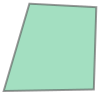

In [ ]:
solarpanels_gpd.loc[2].geometry

In [ ]:
fig = px.scatter_mapbox(
    clusters,
    lat="latitude",
    lon="longitude",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=5,
    title='Fires Clustered by DBSCAN'
)

# Plot the Polygons
for i, row in solarpanels_gpd.iterrows():
    polygon = go.Scattermapbox(
        lat=[point[1] for point in list(row['geometry'].exterior.coords)],
        lon=[point[0] for point in list(row['geometry'].exterior.coords)],
        mode="lines",
        line=dict(color='white'),
        fill='toself',
        fillcolor='rgba(255,0,0,0.3)',
        showlegend=False
    )
    fig.add_trace(polygon)

fig.update_layout(
    mapbox_style='satellite',
    title='Fires Clustered by DBSCAN',
    height=800
)

# Show the plot
fig.show()

NameError: name 'clusters' is not defined

In [ ]:
# Merge all polygons df
ignore_areas = solarpanels_gpd.copy()

# Invert the ignore areas latitude and longitude example: {-70, -30} to {-30, -70}
for i, row in ignore_areas.iterrows():
    ignore_areas.loc[i, 'geometry'] = Polygon([(p[1], p[0]) for p in list(row['geometry'].exterior.coords)])

# Add volcanoes
ignore_areas = pd.concat([ignore_areas, geo_df], ignore_index=True).drop(columns=['cluster'])
print(ignore_areas.iloc[0].item())

NameError: name 'geo_df' is not defined

In [ ]:
# Add a fig with map
fig = px.scatter_mapbox(
    clusters,
    lat="latitude",
    lon="longitude",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=5,
    title='Fires Clustered by DBSCAN'
)

# Plot the areas
for i, row in ignore_areas.iterrows():
    min_lat, min_lon, max_lat, max_lon = row['geometry'].bounds

    rectangle = go.Scattermapbox(
        lat=[min_lat, max_lat, max_lat, min_lat, min_lat],
        lon=[min_lon, min_lon, max_lon, max_lon, min_lon],
        mode="lines",
        line=dict(color='white'),
        fill='toself',
        fillcolor='rgba(255,0,0,0.3)',
        showlegend=False
    )
    fig.add_trace(rectangle)

fig.update_layout(
    mapbox_style='satellite',
    title='Fires Clustered by DBSCAN',
    height=800
)

# Show the plot
fig.show()

In [ ]:
# Filter out points that are in the ignore areas
filtered_points = filter_by_area(points_df, ignore_areas)
filtered_points

,id,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,ftype
0,799,-34.32245,-70.73393,304.85,0.40,0.44,2024-01-12,518,1,VIIRS,n,2.0NRT,286.28,0.73,N,NaN
1,800,-34.10534,-70.45562,340.10,0.39,0.44,2024-01-12,518,1,VIIRS,n,2.0NRT,286.28,6.41,N,NaN
2,801,-33.29236,-70.72990,315.81,0.42,0.45,2024-01-12,518,1,VIIRS,n,2.0NRT,282.05,2.06,N,NaN
3,802,-32.80292,-70.95407,306.76,0.44,0.46,2024-01-12,518,1,VIIRS,n,2.0NRT,286.78,1.93,N,NaN
6,805,-36.78181,-73.13027,299.19,0.47,0.48,2024-01-12,520,1,VIIRS,n,2.0NRT,283.01,1.06,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,993,-33.28785,-70.59742,354.92,0.45,0.63,2024-01-12,1921,1,VIIRS,n,2.0NRT,310.81,30.88,D,NaN
195,994,-33.28691,-70.59388,367.00,0.45,0.63,2024-01-12,1921,1,VIIRS,h,2.0NRT,307.15,41.87,D,NaN
196,995,-33.28405,-70.58311,367.00,0.46,0.63,2024-01-12,1921,1,VIIRS,h,2.0NRT,302.43,97.98,D,NaN
197,996,-31.00283,-70.51562,345.33,0.53,0.67,2024-01-12,1921,1,VIIRS,n,2.0NRT,309.77,24.24,D,NaN


In [ ]:
# Add a fig with map
fig = px.scatter_mapbox(
    filtered_points,
    lat="latitude",
    lon="longitude",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=5,
    title='Fires Clustered by DBSCAN'
)

fig.update_layout(
    mapbox_style='satellite',
    title='Fires Clustered by DBSCAN',
    height=800
)

# Show the plot
fig.show()

In [ ]:
ignore_areas.to_csv('ignore_areas.csv')

NameError: name 'ignore_areas' is not defined

Test

In [ ]:
df_comunas = gpd.read_file('../django-api/api/data/comunas.geojson', driver='GeoJSON')

In [ ]:
df_comunas

,comuna,geometry
0,AISEN,"POLYGON ((-73.40337 -47.06401, -73.62356 -47.0..."
1,ALGARROBO,"POLYGON ((-71.58690 -33.39951, -71.60178 -33.3..."
2,ALHUE,"POLYGON ((-71.07577 -34.18241, -71.07850 -34.1..."
3,ALTO DEL CARMEN,"POLYGON ((-70.08615 -29.53443, -70.13450 -29.5..."
4,ANCUD,"POLYGON ((-73.71700 -42.25159, -73.96007 -42.2..."
...,...,...
336,VITACURA,"POLYGON ((-70.60618 -33.41199, -70.61447 -33.4..."
337,YERBAS BUENAS,"POLYGON ((-71.60451 -35.78780, -71.64547 -35.7..."
338,YUMBEL,"POLYGON ((-72.50800 -37.24850, -72.51050 -37.2..."
339,YUNGAY,"POLYGON ((-72.18342 -37.19847, -72.27206 -37.1..."


In [ ]:
df_areas = gpd.read_file('../django-api/app/data/comunas.geojson', driver='GeoJSON')

In [ ]:
df_areas

,geometry
0,"POLYGON ((-23.44523 -70.01175, -23.44292 -70.0..."
1,"POLYGON ((-23.49678 -69.42842, -23.49680 -69.3..."
2,"POLYGON ((-25.54285 -70.19586, -25.54207 -70.1..."
3,"POLYGON ((-26.31017 -70.23318, -26.31129 -70.2..."
4,"POLYGON ((-26.29090 -69.97671, -26.28880 -69.9..."
5,"POLYGON ((-26.31644 -69.88478, -26.31641 -69.8..."
6,"POLYGON ((-26.32403 -69.94180, -26.32323 -69.9..."
7,"POLYGON ((-26.37505 -70.08840, -26.38204 -70.0..."
8,"POLYGON ((-27.12657 -70.18648, -27.12932 -70.1..."
9,"POLYGON ((-27.08351 -69.94522, -27.09985 -69.8..."
